In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from torch import nn, optim
import torch.nn.functional as F

In [2]:
from torchvision import transforms,datasets

## Prepare some data

In [3]:
class get_train(datasets.Caltech101):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where the type of target specified by target_type.
        """
        import scipy.io

        img = Image.open(os.path.join(self.root,
                                      "101_ObjectCategories",
                                      self.categories[self.y[index]],
                                      "image_{:04d}.jpg".format(self.index[index]))).convert('RGB')

        target = []
        for t in self.target_type:
            if t == "category":
                target.append(self.y[index])
            elif t == "annotation":
                data = scipy.io.loadmat(os.path.join(self.root,
                                                     "Annotations",
                                                     self.annotation_categories[self.y[index]],
                                                     "annotation_{:04d}.mat".format(self.index[index])))
                target.append(data["obj_contour"])
            else:
                raise ValueError("Target type \"{}\" is not recognized.".format(t))
        target = tuple(target) if len(target) > 1 else target[0]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [4]:
train = get_train('./data',transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
]))

In [5]:
# ??train

In [6]:
img,target = train[255]
img.shape,target

(torch.Size([3, 64, 64]), 0)

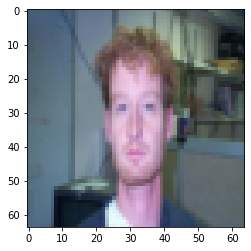

In [7]:
plt.imshow(np.transpose(img,(1,2,0)))

### Setup Dataloader

In [8]:
train_dl = torch.utils.data.DataLoader(
    train,batch_size=64,shuffle=True
)

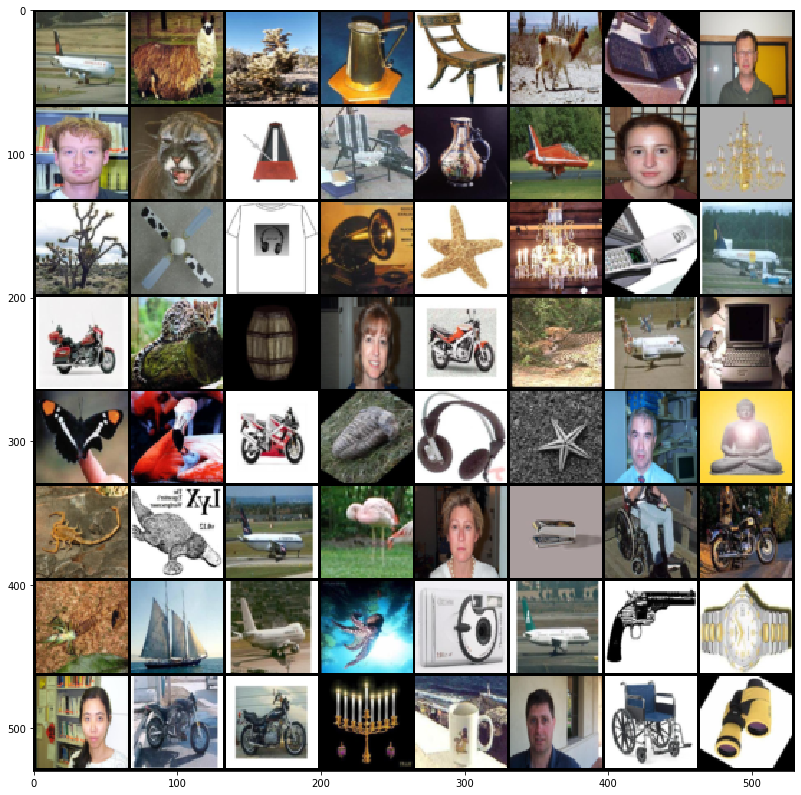

In [9]:
images,labels = next(iter(train_dl))

grid = torchvision.utils.make_grid(images,nrow=8)
plt.figure(figsize=(20,14))
plt.imshow(np.transpose(grid,(1,2,0)))

In [10]:
len(np.unique(train.y))

101

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(3*64*64,512)
        self.fc2 = nn.Linear(512,len(np.unique(train.y)))
    def forward(self,x):
        x = x.view(x.shape[0],-1)
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
#         print('output',x.shape)
        return F.softmax(x,-1)

In [12]:
model = Model()
model

Model(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=101, bias=True)
)

In [13]:
images.shape

torch.Size([64, 3, 64, 64])

In [14]:
model = torchvision.models.resnet18(True).cuda()

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-6,nesterov=True)

In [16]:
def train_one_batch(images,labels):
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    preds = model(images)
    loss = loss_function(preds,labels.detach())
    total_loss.append(loss.item())
    loss.backward()
    optimizer.step()

In [17]:
total_loss = []

In [18]:
%%time
for images,labels in train_dl:
    train_one_batch(images,labels)

CPU times: user 17.7 s, sys: 735 ms, total: 18.5 s
Wall time: 28.6 s


In [19]:
torch.mean(torch.tensor(total_loss))

tensor(2.9884)